## Introduction

As the world continues to deal with the effects of the COVID-19 pandemic, the epidemiological community needs greater understanding on what factors are critical to a person's decision to use one of our greatest preventative tools: the vaccine.

As members of the CDC Vaccine Outreach Task Force, we are entrusted with creating a predictive model that can predict whether or not a person is likely to get a vaccine for a future pandemic based on survey questions and demographic information. With this, the CDC could specifically target the unvaccinated with pro-vaccine recommendations. Additionally,  our model may also shed light on what factors might influence a person to get vaccinated during a pandemic.

## Data Explanation

The dataset for this project was produced by the National 2009 H1N1 Flu Survey, which was performed by automated phone system.

For data download and breakdown of the features:
https://www.drivendata.org/competitions/66/flu-shot-learning/page/211/

## Import Resources

In [3]:
import numpy as np
import pandas as pd
import xlrd
import os
import seaborn as sns
import xgboost
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,\
ExtraTreesClassifier, VotingClassifier, StackingRegressor
from sklearn.metrics import r2_score, accuracy_score, precision_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier

In [4]:
# Read in the data sets
df_features = pd.read_csv('Data/training_set_features.csv')
df_targets = pd.read_csv('Data/training_set_labels.csv')

## Data Exploration

In [5]:
# Merge predictive features and target for convenience
df = df_features.merge(df_targets)

In [6]:
# Examine some data
df.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [7]:
# Get some explanatory information about data
df.describe()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,h1n1_vaccine,seasonal_vaccine
count,26707.000000,26615.000000,26591.000000,26636.000000,26499.000000,26688.000000,26665.000000,26620.00000,26625.000000,26579.000000,...,26316.000000,26319.000000,26312.000000,26245.000000,26193.000000,26170.000000,26458.000000,26458.000000,26707.000000,26707.000000
mean,13353.000000,1.618486,1.262532,0.048844,0.725612,0.068982,0.825614,0.35864,0.337315,0.677264,...,3.850623,2.342566,2.357670,4.025986,2.719162,2.118112,0.886499,0.534583,0.212454,0.465608
std,7709.791156,0.910311,0.618149,0.215545,0.446214,0.253429,0.379448,0.47961,0.472802,0.467531,...,1.007436,1.285539,1.362766,1.086565,1.385055,1.332950,0.753422,0.928173,0.409052,0.498825
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,6676.500000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,...,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,13353.000000,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,...,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000
75%,20029.500000,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,...,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000,1.000000,1.000000,0.000000,1.000000
max,26706.000000,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,3.000000,1.000000,1.000000


In [8]:
# Check data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

In [9]:
# Examine value counts for each feature
for c in df.columns:
    print("---- %s ---" % c)
    print(df[c].value_counts())

---- respondent_id ---
2047     1
7657     1
3371     1
13612    1
15661    1
        ..
12979    1
2740     1
693      1
6838     1
0        1
Name: respondent_id, Length: 26707, dtype: int64
---- h1n1_concern ---
2.0    10575
1.0     8153
3.0     4591
0.0     3296
Name: h1n1_concern, dtype: int64
---- h1n1_knowledge ---
1.0    14598
2.0     9487
0.0     2506
Name: h1n1_knowledge, dtype: int64
---- behavioral_antiviral_meds ---
0.0    25335
1.0     1301
Name: behavioral_antiviral_meds, dtype: int64
---- behavioral_avoidance ---
1.0    19228
0.0     7271
Name: behavioral_avoidance, dtype: int64
---- behavioral_face_mask ---
0.0    24847
1.0     1841
Name: behavioral_face_mask, dtype: int64
---- behavioral_wash_hands ---
1.0    22015
0.0     4650
Name: behavioral_wash_hands, dtype: int64
---- behavioral_large_gatherings ---
0.0    17073
1.0     9547
Name: behavioral_large_gatherings, dtype: int64
---- behavioral_outside_home ---
0.0    17644
1.0     8981
Name: behavioral_outside_home, d

In [10]:
# Generate correlation matrix
df.corr()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,h1n1_vaccine,seasonal_vaccine
respondent_id,1.000000,0.017839,0.003425,-0.008475,0.009638,-0.006644,0.011105,0.004539,0.009011,0.007575,...,0.005912,0.000958,-0.002270,0.005935,-0.005291,0.009563,0.000187,-0.003726,-0.003280,-0.004652
h1n1_concern,0.017839,1.000000,0.062522,0.090301,0.233713,0.156032,0.293565,0.255031,0.246424,0.248016,...,0.239604,0.377033,0.360070,0.235136,0.333990,0.225731,-0.015658,0.050525,0.121929,0.154828
h1n1_knowledge,0.003425,0.062522,1.000000,-0.010836,0.088839,0.030050,0.089785,-0.048898,-0.068219,0.086162,...,0.121009,0.073086,-0.019501,0.086103,0.076825,-0.062483,0.024874,0.050583,0.117951,0.120152
behavioral_antiviral_meds,-0.008475,0.090301,-0.010836,1.000000,0.049247,0.146261,0.064119,0.106287,0.127679,0.070868,...,0.030211,0.105163,0.079091,0.015003,0.085315,0.084305,0.044900,0.084822,0.040608,0.006277
behavioral_avoidance,0.009638,0.233713,0.088839,0.049247,1.000000,0.064946,0.338130,0.227675,0.220348,0.335335,...,0.112300,0.117851,0.131405,0.119554,0.129504,0.082942,0.019122,0.040328,0.047690,0.076395
behavioral_face_mask,-0.006644,0.156032,0.030050,0.146261,0.064946,1.000000,0.083363,0.180907,0.163382,0.104335,...,0.037651,0.131165,0.107129,0.041556,0.110161,0.090009,0.013991,0.005826,0.070498,0.050083
behavioral_wash_hands,0.011105,0.293565,0.089785,0.064119,0.338130,0.083363,1.000000,0.195364,0.192619,0.365064,...,0.136987,0.168711,0.150024,0.138517,0.172464,0.088029,0.009669,0.047764,0.074712,0.112414
behavioral_large_gatherings,0.004539,0.255031,-0.048898,0.106287,0.227675,0.180907,0.195364,1.000000,0.584085,0.253683,...,0.052299,0.126463,0.185924,0.078491,0.132865,0.135446,-0.031938,-0.009449,0.017822,0.064025
behavioral_outside_home,0.009011,0.246424,-0.068219,0.127679,0.220348,0.163382,0.192619,0.584085,1.000000,0.267719,...,0.050748,0.125549,0.174834,0.067469,0.120237,0.138133,-0.027527,-0.009558,0.021768,0.053509
behavioral_touch_face,0.007575,0.248016,0.086162,0.070868,0.335335,0.104335,0.365064,0.253683,0.267719,1.000000,...,0.104126,0.146080,0.131772,0.105798,0.143735,0.090097,-0.000553,0.023606,0.071648,0.120228


One big standout from this correlation matrix are that people with doctor's recommendations often receieved the H1N1 vaccine. The surveyed person's opinions about the vaccine's effectiveness and the danger of the virus were also correlated with vaccination against the disease.

In [11]:
# Check some demographic information
df['age_group'].value_counts()

65+ Years        6843
55 - 64 Years    5563
45 - 54 Years    5238
18 - 34 Years    5215
35 - 44 Years    3848
Name: age_group, dtype: int64

<AxesSubplot: >

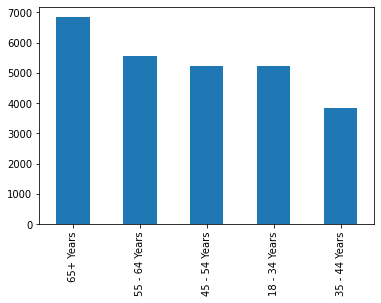

In [12]:
df['age_group'].value_counts().plot(kind = 'bar')

At the time of the survey, the population above 65 years old in the USA was around 12%. [Source](https://www.census.gov/data/tables/2009/demo/age-and-sex/2009-age-sex-composition.html) However, in this survey the population above 65 years of age makes up 25% of the data! The elderly population are overrepresented which may be due to non-response bias. This imbalance should be considered when examining the model's generalizability to future data sets.

## More EDA Visualizations

In [13]:
counts = (df[['h1n1_concern', 'h1n1_vaccine']]
              .groupby(['h1n1_concern', 'h1n1_vaccine'])
              .size()
              .unstack('h1n1_vaccine')
         )
counts


h1n1_vaccine,0,1
h1n1_concern,,
0.0,2849,447
1.0,6756,1397
2.0,8102,2473
3.0,3250,1341


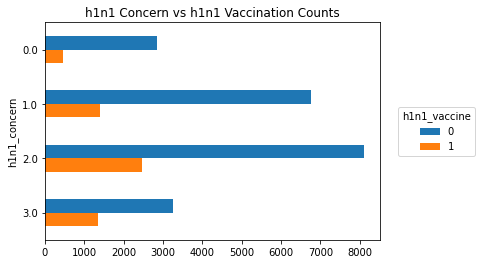

In [14]:
ax = counts.plot.barh()
ax.invert_yaxis()
ax.set_title("h1n1 Concern vs h1n1 Vaccination Counts")
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.3, 0.5), 
    title='h1n1_vaccine'
)

In [15]:
#Since the Two classes are imbalanced, we'll just see vaccinated observations as a smaller number at every level of h1n1_concern.
#We will look at the rate of vaccination for each level of h1n1_concern.

h1n1_concern_counts = counts.sum(axis='columns')
h1n1_concern_counts

h1n1_concern
0.0     3296
1.0     8153
2.0    10575
3.0     4591
dtype: int64

In [16]:
props = counts.div(h1n1_concern_counts, axis='index')
props

h1n1_vaccine,0,1
h1n1_concern,,
0.0,0.864381,0.135619
1.0,0.828652,0.171348
2.0,0.766147,0.233853
3.0,0.707907,0.292093


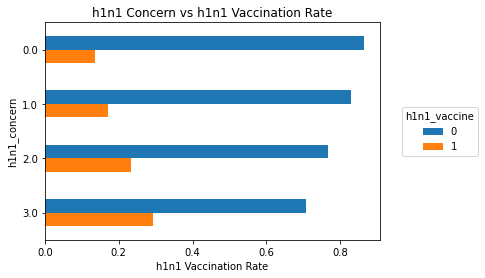

In [17]:
ax = props.plot.barh()
ax.invert_yaxis()
ax.set_title("h1n1 Concern vs h1n1 Vaccination Rate")
ax.set_xlabel("h1n1 Vaccination Rate")
ax.legend(
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5),
    title='h1n1_vaccine'
)

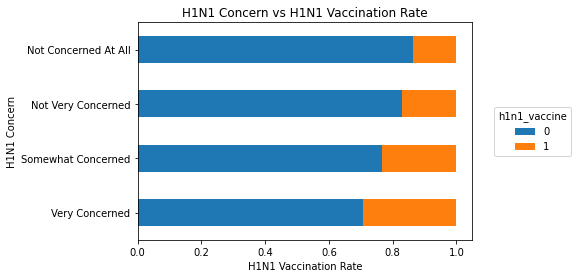

In [18]:
#Visually, we can better see that more people are likely to get the H1N1 vaccine if they have a higher level of concern. 
#Stacked bar chart is a better way to visually read this info. 

concern_levels = ["Not Concerned At All", "Not Very Concerned","Somewhat Concerned","Very Concerned"]
y_pos = np.arange(len(concern_levels))



ax = props.plot.barh(stacked=True)
ax.set_yticks(y_pos, labels = concern_levels)
ax.invert_yaxis()
ax.set_title("H1N1 Concern vs H1N1 Vaccination Rate")
ax.set_xlabel("H1N1 Vaccination Rate")
ax.set_ylabel("H1N1 Concern")
ax.set_label(['Unvaccinated','Vaccinated'])




ax.legend(
    
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5),
    title='h1n1_vaccine'
    
)


In [23]:
#Same Visualiziation process for H1N1 Knowledge

h1n1_knowledge_counts = (df[['h1n1_knowledge', 'h1n1_vaccine']]
              .groupby(['h1n1_knowledge', 'h1n1_vaccine'])
              .size()
              .unstack('h1n1_vaccine'))

h1n1_knowledge_total_counts = h1n1_knowledge_counts.sum(axis='columns')

h1n1_knowledge_props = h1n1_knowledge_counts.div(h1n1_knowledge_total_counts, axis='index')



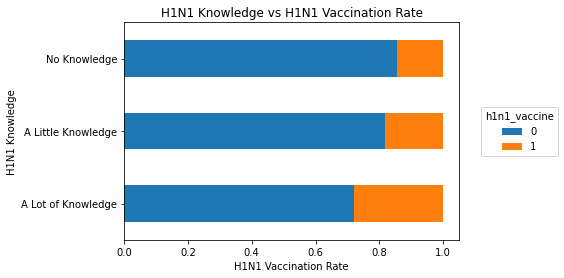

In [24]:
knowledge_levels = ["No Knowledge", "A Little Knowledge","A Lot of Knowledge"]


ax = h1n1_knowledge_props.plot.barh(stacked=True)
y_pos = np.arange(len(knowledge_levels))
ax.set_yticks(y_pos, labels = knowledge_levels)
ax.invert_yaxis()
ax.set_title("H1N1 Knowledge vs H1N1 Vaccination Rate")
ax.set_xlabel("H1N1 Vaccination Rate")
ax.set_ylabel("H1N1 Knowledge")
ax.legend(
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5),
    title='h1n1_vaccine'
)

In [25]:
#Visualization Process for H1N1 Vaccine Effectiveness Opinion

opinion_h1n1_vacc_effective_counts = (df[['opinion_h1n1_vacc_effective', 'h1n1_vaccine']]
              .groupby(['opinion_h1n1_vacc_effective', 'h1n1_vaccine'])
              .size()
              .unstack('h1n1_vaccine')
         )

opinion_h1n1_vacc_effective_total_counts = opinion_h1n1_vacc_effective_counts.sum(axis='columns')

opinion_h1n1_vacc_effective_props = opinion_h1n1_vacc_effective_counts.div(
                                    opinion_h1n1_vacc_effective_total_counts, axis='index')



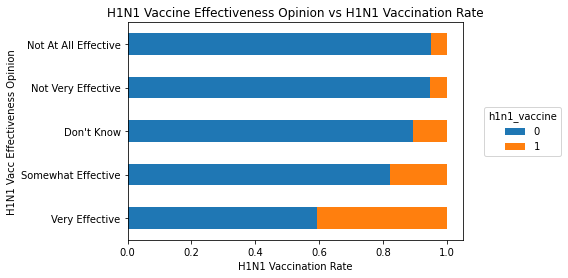

In [26]:
ax = opinion_h1n1_vacc_effective_props.plot.barh(stacked=True)

effectiveness_opinion = ["Not At All Effective", "Not Very Effective","Don't Know", "Somewhat Effective","Very Effective"]
y_pos = np.arange(len(effectiveness_opinion))
ax.set_yticks(y_pos, labels = effectiveness_opinion)
ax.invert_yaxis()
ax.set_title("H1N1 Vaccine Effectiveness Opinion vs H1N1 Vaccination Rate")
ax.set_xlabel("H1N1 Vaccination Rate")
ax.set_ylabel("H1N1 Vacc Effectiveness Opinion")
ax.legend(
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5),
    title='h1n1_vaccine'
)

In [27]:
#Visualization Process for H1N1 Risk Opinion

opinion_h1n1_risk_counts = (df[['opinion_h1n1_risk', 'h1n1_vaccine']]
              .groupby(['opinion_h1n1_risk', 'h1n1_vaccine'])
              .size()
              .unstack('h1n1_vaccine')
                             )

opinion_h1n1_risk_total_counts = opinion_h1n1_risk_counts.sum(axis='columns')

opinion_h1n1_risk_props = opinion_h1n1_risk_counts.div(opinion_h1n1_risk_total_counts, axis='index')



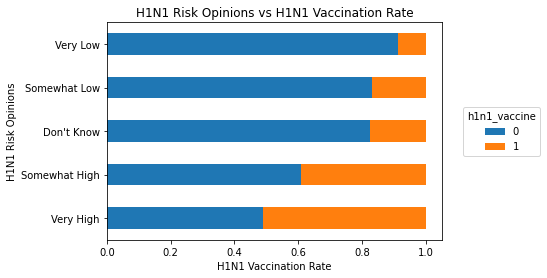

In [28]:
ax = opinion_h1n1_risk_props.plot.barh(stacked=True)

h1n1_risk_opinion = ["Very Low", "Somewhat Low","Don't Know", "Somewhat High","Very High"]
y_pos = np.arange(len(h1n1_risk_opinion))
ax.set_yticks(y_pos, labels = h1n1_risk_opinion)
ax.invert_yaxis()
ax.set_title("H1N1 Risk Opinions vs H1N1 Vaccination Rate")
ax.set_xlabel("H1N1 Vaccination Rate")
ax.set_ylabel("H1N1 Risk Opinions")
ax.legend(
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5),
    title='h1n1_vaccine'
)

The EDA visuals shows a trend of the greater the H1N1 Concern, H1N1 Knowledge, H1N1 Vaccine Effectivness Opinion, and H1N1 Risk Opinions, the greater chance the person will be vaccinated to H1N1. 

## Preprocessing

In [13]:
# Check out missing values
df.isna().sum()

respondent_id                      0
h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
m

There is clearly a lot of missing data here. Because of the nature of the survey, many people likely omitted some information volunatarily or did not fully complete the survey. Since so many values are missing, imputation will be needed in order to maintain the size of the data set.

In [14]:
# Missing or irrelevant data
drop = ['respondent_id', 'doctor_recc_seasonal', 'opinion_seas_vacc_effective', 'opinion_seas_risk',
                'opinion_seas_sick_from_vacc', 'seasonal_vaccine', 'health_insurance', 'employment_industry', 'employment_occupation']

# Impute with most frequent
most_frequent = ['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds', 'behavioral_avoidance', 
                'behavioral_face_mask', 'behavioral_wash_hands', 'behavioral_large_gatherings', 
                'behavioral_outside_home', 'behavioral_touch_face', 'doctor_recc_h1n1', 'chronic_med_condition',
                'child_under_6_months', 'health_worker', 'health_insurance', 'opinion_h1n1_vacc_effective',
                'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc', 'income_poverty', 'marital_status',
                'rent_or_own', 'employment_status', 'household_adults', 'household_children', 'education']


**Missing or irrelevant data**: In order to better relate our results to the COVID-19 pandemic, we are choosing to eliminate the features that pertain to the seasonal flu vaccine and instead focus on the H1N1 vaccination data. We have also dropped the unique identifier as well as the employment and insurance columns which were missing around half of their entries.

**Impute with most frequent**: Due to the categorical nature of the data, we decided that imputation with the most frequent result would be appropriate to cover the smaller holes in the data.

In [15]:
# Drop columns
df = df.drop(drop, axis=1)

In [16]:
# Perform a train test split before any imputation to prevent data leakage
X = df.drop('h1n1_vaccine', axis=1)
y = df['h1n1_vaccine']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Impute missing values with most common result
X_train = X_train.fillna(df.mode().iloc[0])
X_test = X_test.fillna(df.mode().iloc[0])

In [ ]:
# Encoding and scaling
cat_cols = ['age_group', 'education', 'race', 'sex', 'income_poverty', 'marital_status', 'rent_or_own', 'employment_status',
       'hhs_geo_region', 'census_msa']

num_cols = ['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds', 'behavioral_avoidance', 
                'behavioral_face_mask', 'behavioral_wash_hands', 'behavioral_large_gatherings', 
                'behavioral_outside_home', 'behavioral_touch_face', 'doctor_recc_h1n1', 'chronic_med_condition',
                'child_under_6_months', 'health_worker', 'health_insurance', 'opinion_h1n1_vacc_effective',
                'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc',
                'household_adults', 'household_children']

We have separated out the categorical columns from the ones with numeric data to prepare for encoding and scaling.

In [18]:
# OneHotEncode the categorical columns, scale the numerical
ct = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(drop='first'), cat_cols),
    ('scaler', MinMaxScaler(), num_cols)
], remainder='passthrough')

In [19]:
# Perform transformations
ct.fit(X_train)
X_train_trans = ct.transform(X_train)
X_test_trans = ct.transform(X_test)

In [21]:
# Fetch column names
ohe_col_names = ct.named_transformers_['ohe'].get_feature_names(input_features = cat_cols)

# Rebuild transformed dataframe with column names
X_train_trans = pd.DataFrame(X_train_trans,
             columns = [*ohe_col_names, *num_cols], # Using * to unpack lists
             index = X_train.index)

X_test_trans = pd.DataFrame(X_test_trans,
             columns = [*ohe_col_names, *num_cols], # Using * to unpack lists
             index = X_test.index)

In [22]:
# Check transformed dataframe
X_train_trans.describe()

,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,education_< 12 Years,education_College Graduate,education_Some College,race_Hispanic,race_Other or Multiple,race_White,...,doctor_recc_h1n1,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,household_adults,household_children
count,21365.000000,21365.000000,21365.000000,21365.000000,21365.000000,21365.000000,21365.00000,21365.000000,21365.000000,21365.000000,...,21365.000000,21365.000000,21365.000000,21365.000000,21365.000000,21365.000000,21365.000000,21365.000000,21365.000000,21365.000000
mean,0.142944,0.195834,0.208799,0.255277,0.087760,0.430049,0.26520,0.066136,0.061877,0.794477,...,0.203651,0.274561,0.079616,0.110414,0.935081,0.712790,0.335174,0.338942,0.296653,0.176940
std,0.350024,0.396851,0.406460,0.436027,0.282953,0.495094,0.44145,0.248526,0.240937,0.404093,...,0.402722,0.446303,0.270704,0.313413,0.246389,0.250402,0.319782,0.338335,0.250323,0.308851
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.500000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.750000,0.250000,0.250000,0.333333,0.000000
75%,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.00000,0.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.750000,0.750000,0.333333,0.333333
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [23]:
X_train_trans.columns

Index(['age_group_35 - 44 Years', 'age_group_45 - 54 Years',
       'age_group_55 - 64 Years', 'age_group_65+ Years',
       'education_< 12 Years', 'education_College Graduate',
       'education_Some College', 'race_Hispanic', 'race_Other or Multiple',
       'race_White', 'sex_Male', 'income_poverty_> $75,000',
       'income_poverty_Below Poverty', 'marital_status_Not Married',
       'rent_or_own_Rent', 'employment_status_Not in Labor Force',
       'employment_status_Unemployed', 'hhs_geo_region_bhuqouqj',
       'hhs_geo_region_dqpwygqj', 'hhs_geo_region_fpwskwrf',
       'hhs_geo_region_kbazzjca', 'hhs_geo_region_lrircsnp',
       'hhs_geo_region_lzgpxyit', 'hhs_geo_region_mlyzmhmf',
       'hhs_geo_region_oxchjgsf', 'hhs_geo_region_qufhixun',
       'census_msa_MSA, Principle City', 'census_msa_Non-MSA', 'h1n1_concern',
       'h1n1_knowledge', 'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_

## Dummy Classifier

In order to form a baseline for us to compare our models to, we have created a dummy classifier that always predicts the most common result.

The primary metric we are interested in is precision. Precision is sensitive to the number of false positives, and the CDC wants to minimize the chance that an unvaccinated person does not receive potentially life-saving information by being misidentified as someone who is vaccinated.

In [24]:
# Dummy model, chooses most frequent as prediction
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train_trans, y_train)

dummy_preds = dummy.predict(X_test_trans)

print(accuracy_score(y_test, dummy_preds))
print(precision_score(y_test, dummy_preds))

0.7884687383002621
0.0


C:\Users\Patrick\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
# Check the frequencies of predictions
(unique, counts) = np.unique(dummy_preds, return_counts=True)

frequencies = np.asarray((unique, counts)).T

print(frequencies)

[[   0 5342]]


With our baseline, lets perform gridsearches on several models to get an idea of which has the best performance.

## Decision Tree Gridsearch

In [13]:
treepipe = Pipeline([
    ('tree', DecisionTreeClassifier())
])

# Parameters for the grid search
parameters = {
    'tree__criterion': ['gini', 'entropy'],
    'tree__max_depth': list(range(10)[1:]),
    'tree__min_samples_leaf': list(range(10))[1:],
    'tree__random_state': [42]
}

# Perform grid search prioritizing precision
cv_tree = GridSearchCV(treepipe, param_grid=parameters, scoring='precision')

# Fit grid search and predict
cv_tree.fit(X_train_trans, y_train)
y_pred_tree = cv_tree.predict(X_test_trans)

[0 0 0 ... 0 0 0]


In [14]:
# Ideal parameters
cv_tree.best_params_

{'tree__criterion': 'gini',
 'tree__max_depth': 2,
 'tree__min_samples_leaf': 1,
 'tree__random_state': 42}

In [15]:
# Precision score
cv_tree.best_score_

0.6885314980379216

## Logistic Gridsearch

In [18]:
logpipe = Pipeline([
    ('logistic', LogisticRegression())
])

# Parameters for the grid search
parameters = {
    'logistic__C': [1, 10, 100, 1000, 10000, 100000],
    'logistic__class_weight': [None, 'balanced'],
    'logistic__random_state': [42]
}

# Perform grid search prioritizing precision
cv_log = GridSearchCV(logpipe, param_grid=parameters, scoring='precision')

# Fit grid search and predict
cv_log.fit(X_train_trans, y_train)
y_pred_log = cv_log.predict(X_test_trans)

[0 0 0 ... 1 0 0]


In [19]:
# Ideal parameters
cv_log.best_params_

{'logistic__C': 1,
 'logistic__class_weight': None,
 'logistic__random_state': 42}

In [20]:
# Precision score
cv_log.best_score_

0.6812667659379484

## KNN Gridsearch

In [13]:
knnpipe = Pipeline([
    ('KNN', KNeighborsClassifier())
])

# Parameters for the grid search
parameters = {
    'KNN__n_neighbors': [9, 10, 11, 12, 13, 14, 15]
}

# Perform grid search prioritizing precision
cv_knn = GridSearchCV(knnpipe, param_grid=parameters, scoring='precision')

# Fit grid search and predict
cv_knn.fit(X_train_trans, y_train)
y_pred_knn = cv_knn.predict(X_test_trans)

[0 0 0 ... 0 0 0]


In [15]:
# Ideal parameters
cv_knn.best_params_

{'KNN__n_neighbors': 14}

In [16]:
# Precision score
cv_knn.best_score_

0.6960868654302264

## Forest Gridsearch

In [26]:
# Suppress an unneeded warning
import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"

In [66]:
forestpipe = Pipeline([
    ('forest', RandomForestClassifier())
])

# Parameters for the grid search
parameters = {
    'forest__n_estimators': [50, 55, 60, 65, 70, 75, 80],
    'forest__criterion': ['gini', 'entropy', 'log_loss'],
    'forest__max_depth': list(range(7)[1:]),
    'forest__random_state': [42]
}

# Perform grid search prioritizing precision
cv_forest = GridSearchCV(forestpipe, param_grid=parameters, scoring='precision')

# Fit grid search and predict
cv_forest.fit(X_train_trans, y_train)
y_pred_forest = cv_forest.predict(X_test_trans)
print(y_pred_forest)

[0 0 0 ... 0 0 0]


In [90]:
# Ideal parameters
cv_forest.best_params_

{'forest__criterion': 'entropy',
 'forest__max_depth': 3,
 'forest__n_estimators': 60,
 'forest__random_state': 42}

In [91]:
# Precision score
cv_forest.best_score_

0.9008547008547009

This model had the highest precision so far. Let's examine it further.

In [92]:
# Accuracy score
accuracy_score(y_test, y_pred_forest)

0.7920254586297267

Compared to baseline, the accuracy of this model is very low. It may be making very few positive (vaccinated) predictions.

In [67]:
# Check prediction frequencies
(unique, counts) = np.unique(y_pred_forest, return_counts=True)

frequencies = np.asarray((unique, counts)).T

print(frequencies)

[[   0 5321]
 [   1   21]]


As expected, the model is being very precious about classifying someone as vaccinated. If the CDC is most concerned with ensuring the information goes out to as many possible people, this model performs well. However, if sending almost everyone information is impossible due to budget constraint, the model may need to be tuned to have a higher accuracy.

In [74]:
# Create randomforest model with ideal parameters
best_forest = RandomForestClassifier(criterion='entropy',
 max_depth=3,
 n_estimators=60,
 random_state=42)

best_forest.fit(X_train_trans, y_train)
y_pred_best_forest = best_forest.predict(X_test_trans)

In [89]:
# List out most important features
important_features_dict = {}
for idx, val in enumerate(best_forest.feature_importances_):
    important_features_dict[idx] = val

important_features_list = sorted(important_features_dict,
                                 key=important_features_dict.get,
                                 reverse=True)

for x in important_features_list[:15] :
    print(X_train_trans.columns[x])

doctor_recc_h1n1
opinion_h1n1_risk
opinion_h1n1_vacc_effective
health_worker
h1n1_knowledge
chronic_med_condition
opinion_h1n1_sick_from_vacc
h1n1_concern
behavioral_touch_face
child_under_6_months


## Bagging

Perhaps caggregating several of the earlier models will outperform the random forest classifier.

In [17]:
# Instantiate the member models
bag_tree = DecisionTreeClassifier(max_depth=2, min_samples_leaf=4, random_state=42)
bag_log = LogisticRegression(random_state=42)
bag_knn = KNeighborsClassifier(n_neighbors=14)

In [18]:
# Using voting classifier to combine models
avg = VotingClassifier(estimators=[
    ('tree', bag_tree),
    ('log', bag_log),
    ('knn', bag_knn)])
avg.fit(X_train_trans, y_train)

VotingClassifier(estimators=[('tree',
                              DecisionTreeClassifier(max_depth=2,
                                                     min_samples_leaf=4,
                                                     random_state=42)),
                             ('log', LogisticRegression(random_state=42)),
                             ('knn', KNeighborsClassifier(n_neighbors=14))])

In [19]:
# Cross validate
scores = cross_val_score(estimator=avg, X=X_train_trans,
               y=y_train, cv=5)
scores

array([0.82167096, 0.82026679, 0.8254154 , 0.82869179, 0.82377721])

In [20]:
# Generate predictions and precision score
avg_preds = avg.predict(X_test_trans)

precision_score(y_test, avg_preds)

The bagging model performed pretty well, but was still weaker than the random forest. Let's see if a boosting model can outperform it.

## Boost

In order to attempt a boost model, some of the columns need to be renamed to avoid prohibited characters.

In [30]:
# Rename columns with prohibited symbols
X_train_trans_boost = X_train_trans.copy()
X_test_boost = X_test_trans.copy()
X_train_trans_boost.rename(columns={"education_< 12 Years": "education_greater_12_years", 
                                    "income_poverty_> $75,000": "income_poverty_greater_$75000"}, inplace=True)
X_test_boost.rename(columns={"education_< 12 Years": "education_greater_12_years", 
                                    "income_poverty_> $75,000": "income_poverty_greater_$75000"}, inplace=True)

In [44]:
boostpipe = Pipeline([
    ('boost', xgboost.XGBClassifier())
])

# Parameters for grid search
parameters = {
    'boost__max_depth': [2, 3, 4, 5, 6, 7],
    'boost__n_estimators': [25, 50, 75, 100, 125, 150],
    'boost__random_state': [42]
}

# Grid search with boost model
cv_boost = GridSearchCV(boostpipe, param_grid=parameters, scoring='precision')

# Fit model and generate predictions
cv_boost.fit(X_train_trans_boost, y_train)
y_pred_boost = cv_boost.predict(X_test_boost)

[0 0 0 ... 1 0 0]


In [46]:
# Ideal parameters
cv_boost.best_params_

{'boost__max_depth': 3, 'boost__n_estimators': 25, 'boost__random_state': 42}

In [47]:
# Precision score
cv_boost.best_score_

0.6855399145618978